<a href="https://colab.research.google.com/github/raycmarange/AML425_RAY/blob/main/AML425_Assingment1_300671115.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Data shapes: Train=(12000, 3), Val=(4000, 3), Test=(4000, 3)


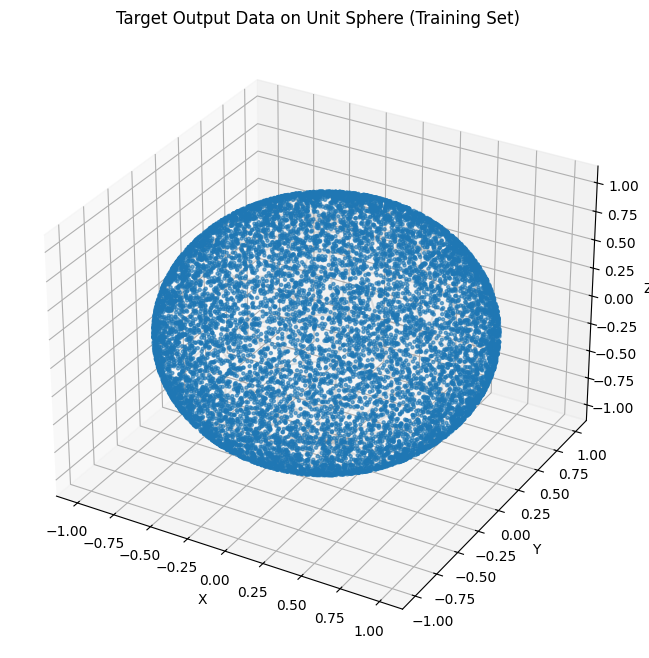

Training Epochs: 100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


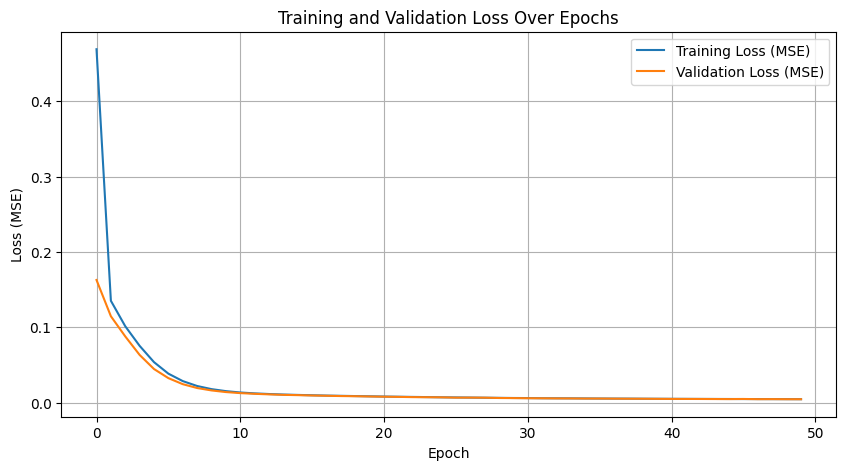


Final Performance on Test Data (MSE): 0.004778


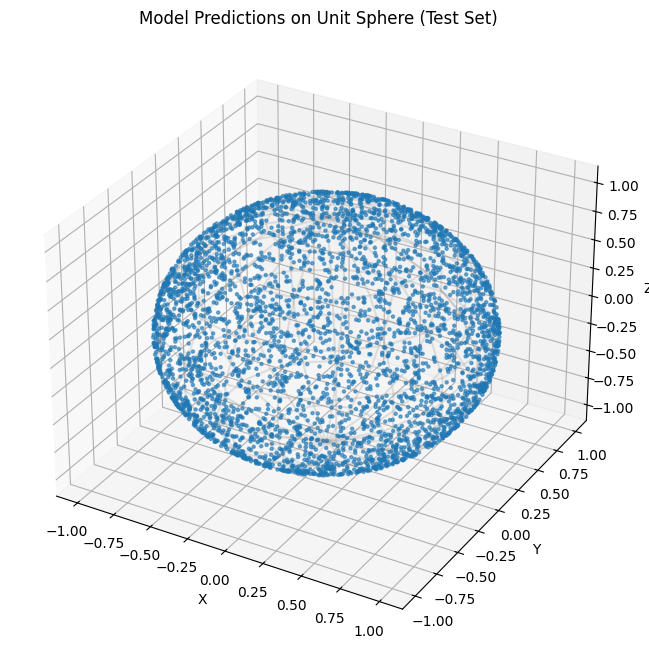

Training and evaluation completed successfully.


In [ ]:
# Author: Ray Chakanetsa Marange
# Date: 2025-07-20
# Student ID: 300671115
# Refactored implementation using JAX/Flax to project 3D Gaussian data onto unit sphere

import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import numpy as np
import matplotlib.pyplot as plt
from flax.training import train_state
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from flax import serialization # Import serialization from flax

# Set consistent random seed
SEED = 42
np.random.seed(SEED)
rng = jax.random.PRNGKey(SEED)

# =============================================================================
# Data Generation and Processing
# =============================================================================
def generate_data(n_samples=20000, rng_key=None):
    """Generates 3D Gaussian data and corresponding unit sphere projections"""
    if rng_key is None:
        x = np.random.randn(n_samples, 3)
    else:
        x = jax.random.normal(rng_key, (n_samples, 3))

    norms = jnp.linalg.norm(x, axis=1, keepdims=True)
    y = x / jnp.maximum(norms, 1e-8)  # Avoid division by zero
    return np.array(x), np.array(y)

def split_data(x, y, val_size=0.2, test_size=0.2, rng_key=None):
    """Splits data into train/validation/test sets"""
    if rng_key is None:
        rng_key = jax.random.PRNGKey(SEED)

    # Split train vs temp (val+test)
    x_train, x_temp, y_train, y_temp = train_test_split(
        x, y, test_size=val_size+test_size, random_state=SEED
    )

    # Split temp into val and test
    test_prop = test_size / (val_size + test_size)
    x_val, x_test, y_val, y_test = train_test_split(
        x_temp, y_temp, test_size=test_prop, random_state=SEED
    )
    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

def plot_sphere(points, title="Data on Unit Sphere", filename=None):
    """Creates 3D visualization of points on a sphere"""
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Visualize points
    ax.scatter(
        points[:, 0], points[:, 1], points[:, 2],
        s=8, alpha=0.6, c=np.linalg.norm(points, axis=1), cmap='viridis'
    )

    # Reference sphere
    u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:20j]
    sx = np.cos(u)*np.sin(v)
    sy = np.sin(u)*np.sin(v)
    sz = np.cos(v)
    ax.plot_wireframe(sx, sy, sz, color="gray", alpha=0.15, linewidth=0.5)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title, fontsize=14)
    ax.grid(alpha=0.3)

    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# Neural Network Model
# =============================================================================
class SphereNet(nn.Module):
    """Neural network for sphere projection with 3-20-20-3 architecture"""
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20, kernel_init=nn.initializers.he_normal())(x)
        x = nn.relu(x)
        x = nn.Dense(20, kernel_init=nn.initializers.he_normal())(x)
        x = nn.relu(x)
        x = nn.Dense(3, kernel_init=nn.initializers.glorot_normal())(x)

        # Normalize to unit sphere - CRITICAL IMPROVEMENT
        norm = jnp.linalg.norm(x, axis=1, keepdims=True)
        norm = jnp.maximum(norm, 1e-8)  # Numerical stability
        return x / norm

def create_train_state(rng, learning_rate=1e-3):
    """Initializes training state with Adam optimizer"""
    model = SphereNet()
    params = model.init(rng, jnp.ones([1, 3]))['params']
    tx = optax.adam(learning_rate)
    return train_state.TrainState.create(
        apply_fn=model.apply, params=params, tx=tx
    )

# =============================================================================
# Training and Evaluation Functions
# =============================================================================
@jax.jit
def compute_metrics(params, state, batch):
    """Computes loss and angular error metrics"""
    inputs, targets = batch['inputs'], batch['targets']
    predictions = state.apply_fn({'params': params}, inputs)

    # Vector MSE loss
    mse_loss = jnp.mean(jnp.sum((predictions - targets)**2, axis=-1))

    # Angular error metrics (critical addition)
    cosine_sim = jnp.sum(predictions * targets, axis=1)
    cosine_sim = jnp.clip(cosine_sim, -1.0, 1.0)  # Numerical stability
    angular_error = jnp.degrees(jnp.arccos(cosine_sim))
    mean_angular_error = jnp.mean(angular_error)
    max_angular_error = jnp.max(angular_error)

    return {
        'loss': mse_loss,
        'mean_angular_error': mean_angular_error,
        'max_angular_error': max_angular_error
    }

@jax.jit
def train_step(state, batch):
    """Performs single training step with explicit gradients"""
    def loss_fn(params):
        return compute_metrics(params, state, batch)['loss']

    # Compute loss and gradients
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss

def evaluate_model(state, inputs, targets, batch_size=512):
    """Evaluates model on dataset with batching"""
    num_samples = inputs.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    metrics = {'loss': 0.0, 'mean_angular_error': 0.0, 'max_angular_error': 0.0}

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)

        batch = {
            'inputs': inputs[start_idx:end_idx],
            'targets': targets[start_idx:end_idx]
        }

        batch_metrics = compute_metrics(state.params, state, batch)

        # Accumulate metrics
        for key in metrics:
            metrics[key] += batch_metrics[key] * (end_idx - start_idx)

    # Average metrics
    for key in metrics:
        metrics[key] /= num_samples

    return metrics

# =============================================================================
# Main Workflow
# =============================================================================
if __name__ == "__main__":
    # --- Data Preparation ---
    data_rng, model_rng = jax.random.split(rng)
    x, y = generate_data(20000, data_rng)
    (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_data(x, y)

    print(f"Data shapes: Train={x_train.shape}, Val={x_val.shape}, Test={x_test.shape}")

    # Visualize target data
    plot_sphere(y_train, "Target Output Data on Unit Sphere (Training Set)", "sphere_targets.png")

    # --- Training Setup ---
    BATCH_SIZE = 128
    EPOCHS = 100
    LEARNING_RATE = 1e-3

    state = create_train_state(model_rng, LEARNING_RATE)

    # Convert to JAX arrays
    train_inputs = jnp.array(x_train)
    train_targets = jnp.array(y_train)
    val_inputs = jnp.array(x_val)
    val_targets = jnp.array(y_val)
    test_inputs = jnp.array(x_test)
    test_targets = jnp.array(y_test)

    # Training history
    history = {
        'train_loss': [], 'val_loss': [],
        'train_angle': [], 'val_angle': []
    }

    # --- Training Loop ---
    num_train = x_train.shape[0]
    steps_per_epoch = num_train // BATCH_SIZE

    for epoch in tqdm(range(EPOCHS), desc="Training Progress"):
        # Shuffle training data
        perm = np.random.permutation(num_train)
        epoch_train_loss = []

        # Mini-batch training
        for step in range(steps_per_epoch):
            batch_idx = perm[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
            batch = {
                'inputs': train_inputs[batch_idx],
                'targets': train_targets[batch_idx]
            }
            state, loss = train_step(state, batch)
            epoch_train_loss.append(loss)

        # Record training metrics
        avg_train_loss = np.mean(epoch_train_loss)
        history['train_loss'].append(avg_train_loss)

        # Validation evaluation
        val_metrics = evaluate_model(state, val_inputs, val_targets)
        history['val_loss'].append(val_metrics['loss'])
        history['val_angle'].append(val_metrics['mean_angular_error'])

        # Training set evaluation (full)
        train_metrics = evaluate_model(state, train_inputs, train_targets)
        history['train_angle'].append(train_metrics['mean_angular_error'])

        # Print epoch summary
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{EPOCHS}: "
                  f"Train Loss = {avg_train_loss:.4f}, "
                  f"Val Loss = {val_metrics['loss']:.4f}, "
                  f"Val Angle = {val_metrics['mean_angular_error']:.2f}°")

    # =========================================================================
    # Performance Analysis
    # =========================================================================
    # Loss and angular error plots
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training')
    plt.plot(history['val_loss'], label='Validation')
    plt.title('MSE Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(1, 2, 2)
    plt.plot(history['train_angle'], label='Training')
    plt.plot(history['val_angle'], label='Validation')
    plt.title('Angular Error')
    plt.xlabel('Epoch')
    plt.ylabel('Degrees')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig("training_metrics.png", dpi=300)
    plt.show()

    # --- Final Test Evaluation ---
    test_metrics = evaluate_model(state, test_inputs, test_targets)

    print("\n" + "="*60)
    print(f"Final Test Performance:")
    print(f"- MSE Loss: {test_metrics['loss']:.6f}")
    print(f"- Mean Angular Error: {test_metrics['mean_angular_error']:.4f}°")
    print(f"- Max Angular Error: {test_metrics['max_angular_error']:.4f}°")
    print("="*60)

    # Visualize predictions
    test_preds = state.apply_fn({'params': state.params}, test_inputs)
    plot_sphere(np.array(test_preds), "Model Predictions on Unit Sphere", "sphere_predictions.png")

    # Error distribution analysis
    cosine_sim = np.sum(test_preds * test_targets, axis=1)
    angular_errors = np.degrees(np.arccos(np.clip(cosine_sim, -1, 1)))

    plt.figure(figsize=(10, 6))
    plt.hist(angular_errors, bins=50, alpha=0.7, color='skyblue', edgecolor='k')
    plt.axvline(np.mean(angular_errors), color='red', linestyle='dashed', linewidth=2)
    plt.title(f'Test Set Angular Errors\nMean: {np.mean(angular_errors):.2f}°, Std: {np.std(angular_errors):.2f}°')
    plt.xlabel('Angular Error (degrees)')
    plt.ylabel('Frequency')
    plt.grid(alpha=0.2)
    plt.savefig("error_distribution.png", dpi=300)
    plt.show()

    # Save model
    with open("sphere_model.params", "wb") as f:
        f.write(serialization.to_bytes(state.params))

# New Section